# Derin Öğrenme İçin Aktivasyon Fonksiyonlarının Karşılaştırılması
* Sigmoid Fonksiyonu
* Hiperbolik Tanjant
* ReLU Fonksiyonu
* Leaky-ReLU Fonksiyonu
* Swish Fonksiyonu

## Not : 5 farklı aktivasyon fonksiyonu için kullanacağımızdan modelin 5 kere eğitimini gerçekleştireceğiz.

## Google Colab Kimlik Doğrulama İşlemi

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Kullanılan donanımın bilgilerini görelim

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13117952803247833974
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2952063116354249677
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Kütüphanelerin kurulması ve gerekli importların yapılması adımı

In [3]:
!pip install -q keras

In [4]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras. layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow  as tf
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

## Veri Setinin İndirilmesi

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # kullanacağımız veri seti mnist içerisinde var o sayede direk bu şekildeçekebildik

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Verilerden bir kısım örneğin görselleştirilmesi
Görüp bilgi sahibi olalım , yoksa zorunlu bir durum değil

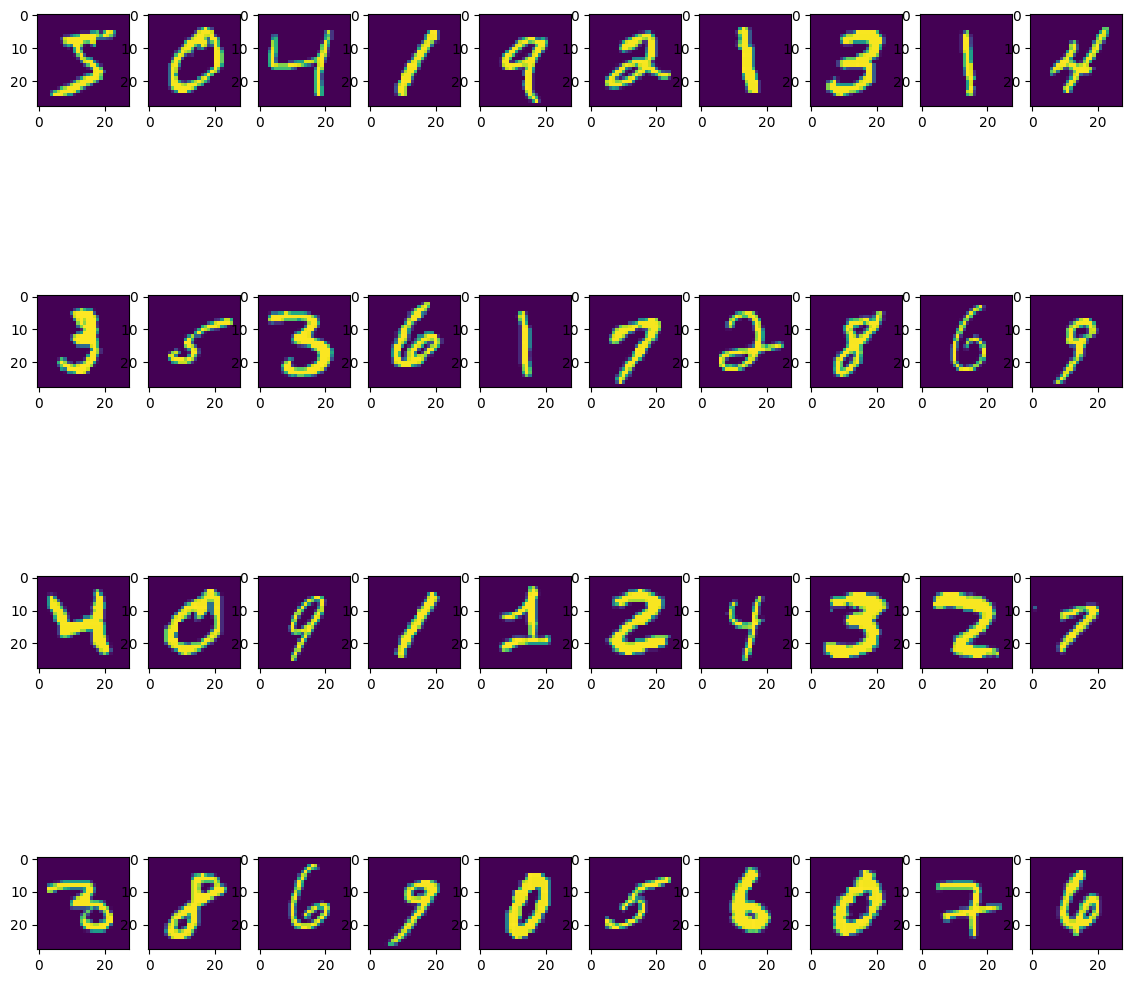

In [6]:
plt.figure(figsize=(14,14))
x, y = 10, 4
for i in range(40):
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i])
plt.show()

## Yapılandırma Ayarları ( Başlangıç Değerleri )

In [7]:
batch_size=128 # Küme boyutu
num_classes=10# Sınıf sayısı
epochs=20 # Eğitim epoch sayısı
w_12=1e-5 # Başlangıç

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

ReduceLROnPlateau fonksiyonu, model eğitiminde öğrenme hızını (learning rate) dinamik olarak azaltmaya yarar. Bu, modelin belirli bir noktada takıldığı veya öğrenme sürecinin yavaşladığı durumlarda öğrenme hızını düşürerek daha iyi sonuçlar elde etmeye yönelik bir stratejidir.<br>
### Parametreler:

* monitor='val_loss':

Bu parametre, izlenmesi gereken metriği belirtir. Burada, doğrulama kaybı (val_loss) izleniyor. Yani, modelin doğrulama setindeki kaybı azalmayı bıraktığında (veya artmaya başladığında), öğrenme oranı düşürülmeye başlanır.
Diğer izlenebilir metrikler, eğitim kaybı (loss), doğruluk (accuracy) gibi ölçütler olabilir.

* factor=0.2:

Öğrenme hızının ne kadar azaltılacağını belirler. factor=0.2 demek, mevcut öğrenme hızını %20'ye düşürmek anlamına gelir. Örneğin, öğrenme hızı 0.001 ise, bu azaltıldığında yeni öğrenme hızı 0.0002 olur.
Öğrenme oranını daha küçük oranlarda veya daha büyük oranlarda azaltmak için bu değeri ayarlayabilirsiniz.

* patience=5:

Bu parametre, izlenen metriğin (örneğin, val_loss) daha iyi hale gelmediği ardışık kaç epoch sonrasında öğrenme hızının düşürüleceğini belirtir. Burada, patience=5 olarak ayarlanmış, yani doğrulama kaybı 5 epoch boyunca iyileşmezse öğrenme oranı düşürülecektir.

* min_lr=1e-5:

Öğrenme hızının düşürülebileceği en düşük değeri belirler. Yani, öğrenme hızı ne kadar azaltılırsa azaltılsın, 0.00001'den daha düşük bir değere inmez. Bu, öğrenme hızının çok küçük bir değere ulaşarak modelin tamamen durmasına neden olmamak için kullanılır.

### Çalışma Prensibi:

Model eğitiminde, doğrulama kaybı (val_loss) izlenir. Doğrulama kaybı belirli bir süre boyunca iyileşmezse (patience süresi boyunca), öğrenme hızı azaltılır (factor ile).
Bu süreç, modelin öğrenme oranını daha küçük adımlarla ayarlayarak, özellikle modelin takıldığı veya aşırı öğrenme yaptığı anlarda öğrenmeyi daha hassas hale getirir.
Öğrenme hızı, modelin öğrenmeye devam etmesine yetecek kadar azaltılabilir ancak min_lr ile belirtilen minimum değerin altına düşmez.
Bu yöntem, eğitim sürecinde daha iyi genel performans elde etmek ve aşırı öğrenme (overfitting) veya öğrenmede duraklama (plateau) gibi sorunları çözmek için kullanılır.

In [9]:
img_rows, img_cols = 28, 28  # Görüntülerin satır ve sütun boyutlarını tanımlama (28x28)

if K.image_data_format() == 'channels_first':  # Keras veriyi "channels_first" formatında mı kullanıyor diye kontrol et
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)  # Eğitim verisini (kanal, satır, sütun) formatında yeniden şekillendir
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)  # Test verisini aynı formatta yeniden şekillendir
    input_shape = (1, img_rows, img_cols)  # Giriş şekli (1, 28, 28) olarak belirlenir
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)  # Eğitim verisini (satır, sütun, kanal) formatında yeniden şekillendir
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)  # Test verisini aynı formatta yeniden şekillendir
    input_shape = (img_rows, img_cols, 1)  # Giriş şekli (28, 28, 1) olarak belirlenir

x_train = x_train.astype('float32')  # Eğitim verisini 'float32' türüne dönüştür
x_test = x_test.astype('float32')  # Test verisini 'float32' türüne dönüştür
x_train /= 255  # Eğitim verilerini 0-1 aralığında normalleştir
x_test /= 255  # Test verilerini 0-1 aralığında normalleştir
print('x_train shape:', x_train.shape)  # Eğitim verisinin yeni şeklini yazdır
print(x_train.shape[0], 'train samples')  # Eğitim örneği sayısını yazdır
print(x_test.shape[0], 'test samples')  # Test örneği sayısını yazdır

# sınıf vektörlerini ikili sınıf matrislerine dönüştürmek
y_train = keras.utils.to_categorical(y_train, num_classes)  # Eğitim sınıf vektörlerini ikili matris formuna dönüştür
y_test = keras.utils.to_categorical(y_test, num_classes)  # Test sınıf vektörlerini ikili matris formuna dönüştür


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Keras Veri Formatına Göre Şekillendirme:

* Keras’ın image_data_format() yöntemi:<br>
verinin hangi formatta olduğunu (channels_first veya channels_last) döndürür.<br>
* channels_first durumunda: x_train ve x_test veri setleri (örnek sayısı, kanal, satır, sütun) formatında şekillendirilir. Grayscale (tek kanal) olduğu için kanal boyutu 1 olarak ayarlanır.<br>
* channels_last durumunda: x_train ve x_test veri setleri (örnek sayısı, satır, sütun, kanal) formatına dönüştürülür.
* Veri Türünü float32 Yapma ve Normalleştirme (x_train = x_train.astype('float32'), x_train /= 255):
Görüntü verileri float32 türüne dönüştürülüyor ve 0-255 arasındaki pikseller 0-1 aralığına normalleştiriliyor. Bu, modelin daha iyi performans göstermesine yardımcı olur.<br>

#### Veri Şekil ve Sayılarını Yazdırma:

x_train.shape ve x_test.shape ile veri şekli ve örnek sayısı kontrol amaçlı ekrana yazdırılır.<br>

#### Sınıf Vektörlerini İkili Matris Formuna Dönüştürme:
y_train ve y_test sınıf etiketleri, to_categorical() fonksiyonu ile kategorik (ikili sınıf matrisi) formuna dönüştürülüyor. Bu işlem, her bir sınıf etiketinin model tarafından tanınabilmesi için gereklidir ve etiketlerin “one-hot” formatında olmasını sağlar.

## Sigmoid Fonksiyonu

In [10]:
from keras import regularizers  # regularizers modülünü ekliyoruz
w_l2 = 0.01  # L2 düzenleme için bir sabit değer belirliyoruz
model = Sequential()  # Modeli sırayla katmanlar ekleyerek oluşturmak için Sequential() kullanılıyor

model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))  # 3x3 boyutunda 32 filtreli bir evrişim katmanı ekleniyor; girdi boyutu input_shape olarak ayarlanıyor ve L2 düzenleme ekleniyor
model.add(BatchNormalization())  # Evrişim katmanının çıktılarını normalize ederek öğrenme sürecini hızlandırır
model.add(Activation('sigmoid'))  # Sigmoid aktivasyon fonksiyonu uygulanıyor

model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(w_l2)))  # 3x3 boyutunda 64 filtreli bir başka evrişim katmanı daha ekleniyor; L2 düzenleme ile
model.add(BatchNormalization())  # Normalizasyon yapılıyor
model.add(Activation('sigmoid'))  # Sigmoid aktivasyon fonksiyonu uygulanıyor

model.add(MaxPooling2D(pool_size=(2, 2)))  # 2x2 boyutunda maksimum havuzlama katmanı ekleniyor; özellik haritasının boyutunu küçültür
model.add(Dropout(0.25))  # %25 oranında dropout uygulanarak aşırı öğrenme (overfitting) riski azaltılır

model.add(Flatten())  # Evrişimsel katmanlardan çıkan 2B veriyi tek boyutlu hale getirir

model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))  # 128 nöronlu bir tam bağlantılı katman ekleniyor, L2 düzenleme ile
model.add(BatchNormalization())  # Normalizasyon yapılıyor
model.add(Activation('sigmoid'))  # Sigmoid aktivasyon fonksiyonu uygulanıyor
model.add(Dropout(0.5))  # %50 dropout oranı ile aşırı öğrenme önlenmeye çalışılıyor

model.add(Dense(num_classes, activation='softmax'))  # Çıktı katmanı; sınıflandırma için sınıf sayısı kadar nöron ve softmax aktivasyon fonksiyonu kullanılıyor

model.compile(loss=keras.losses.categorical_crossentropy,  # Kategorik çapraz entropi kaybı fonksiyonu kullanılıyor
              optimizer=keras.optimizers.Adam(),  # Adam optimizasyon algoritması
              metrics=['accuracy'])  # Doğruluk oranı değerlendirme metriği olarak tanımlanıyor

model.summary()  # Model yapısını özetler, katmanların detaylarını ekrana yazdırır


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

### Modelin Eğitilm ve Test Sonuçları

In [11]:
hist_sigmoid=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.7744 - loss: 1.8722 - val_accuracy: 0.7057 - val_loss: 1.4096 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9208 - loss: 0.7114 - val_accuracy: 0.9090 - val_loss: 0.7380 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9357 - loss: 0.6450 - val_accuracy: 0.8966 - val_loss: 0.7586 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9414 - loss: 0.6240 - val_accuracy: 0.9021 - val_loss: 0.7046 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9437 - loss: 0.6114 - val_accuracy: 0.9661 - val_loss: 0.5690 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9459 - loss: 0.6170 - val_accuracy: 0.7635 - val_loss: 1.1913 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9486 - loss: 0.6039 

### Bu aşamadan itibaren sadece modeli değiştireceğiz

#### Hiperbolik Tanjant Fonksiyonu

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
hist_tanh=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8947 - loss: 1.6790 - val_accuracy: 0.9270 - val_loss: 0.6233 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9552 - loss: 0.4944 - val_accuracy: 0.9648 - val_loss: 0.4443 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9593 - loss: 0.4642 - val_accuracy: 0.9511 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9577 - loss: 0.4808 - val_accuracy: 0.9567 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9581 - loss: 0.4676 - val_accuracy: 0.8883 - val_loss: 0.6620 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9607 - loss: 0.4560 - val_accuracy: 0.9327 - val_loss: 0.5491 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9591 - loss: 0.450

#### ReLU Fonksiyonu

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
hist_relu=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8910 - loss: 1.6415 - val_accuracy: 0.5353 - val_loss: 1.6262 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9583 - loss: 0.4663 - val_accuracy: 0.9717 - val_loss: 0.3982 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9609 - loss: 0.4385 - val_accuracy: 0.9727 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9628 - loss: 0.4089 - val_accuracy: 0.9789 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9628 - loss: 0.3906 - val_accuracy: 0.9780 - val_loss: 0.3233 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9654 - loss: 0.3659 - val_accuracy: 0.9726 - val_loss: 0.3208 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9677 - loss: 0.3437 

#### Leaky (Sızıntı) ReLU Fonksiyonu

In [19]:
# Bu fonksiyon keras içinde advanced activation function olarak tanımlıdır bu yüzen bu fonksiyonu import edip model içinde kullanmamız gerekir.
from tensorflow.keras.layers import LeakyReLU

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=.001))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 24, 24, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,221,450 (4.66 MB)

 Trainable params: 1,221,002 (4.66 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
hist_LeakyReLU=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8869 - loss: 1.6211 - val_accuracy: 0.5158 - val_loss: 2.1593 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9567 - loss: 0.3987 - val_accuracy: 0.9698 - val_loss: 0.3200 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9619 - loss: 0.3418 - val_accuracy: 0.9675 - val_loss: 0.3004 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9633 - loss: 0.3156 - val_accuracy: 0.9627 - val_loss: 0.3011 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9637 - loss: 0.2950 - val_accuracy: 0.9727 - val_loss: 0.2579 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9630 - loss: 0.2864 - val_accuracy: 0.9391 - val_loss: 0.3636 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9666 - loss: 

#### Swish Aktivasyon Fonksiyonunun Tanımlanması

In [27]:
from tensorflow.keras import backend as K
def swish(x):
    return x * K.sigmoid(x)
    # return x * (1/(1 + K.exp(-x)))

In [28]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
hist_swish=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9099 - loss: 2.2543 - val_accuracy: 0.8386 - val_loss: 0.9176 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9606 - loss: 0.5306 - val_accuracy: 0.9721 - val_loss: 0.4066 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9657 - loss: 0.4150 - val_accuracy: 0.9732 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9671 - loss: 0.3860 - val_accuracy: 0.9751 - val_loss: 0.3533 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9678 - loss: 0.3714 - val_accuracy: 0.9775 - val_loss: 0.3261 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9691 - loss: 0.3481 - val_accuracy: 0.9781 - val_loss: 0.3218 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9702 - loss: 0.3523 

### Kaydedilen sonuçların çizilmesi için plot fonksiyonunun tanımlanması

In [30]:
def plot_history(hists, attribute='val_loss', axis=(-1,21,0.85,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acc': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_acc': 'valid. accuracy', 'acc': 'trn. accuracy'}
    num_hists = len(hists)

    plt.figure(figsize=(12, 8))
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])
    plt.ylabel(ylabel[attribute[-3:]])
    plt.xlabel('epoch')
    plt.legend(['Sigmoid', 'tanh', 'ReLU', 'Leaky_ReLU', 'Swish'], loc=loc)

    plt.show()

In [31]:
hists = [hist_sigmoid, hist_tanh, hist_relu, hist_LeakyReLU, hist_swish]

#### SONUÇLARIN KARŞILAŞTIRILMASI

KeyError: 'val_accuracy'

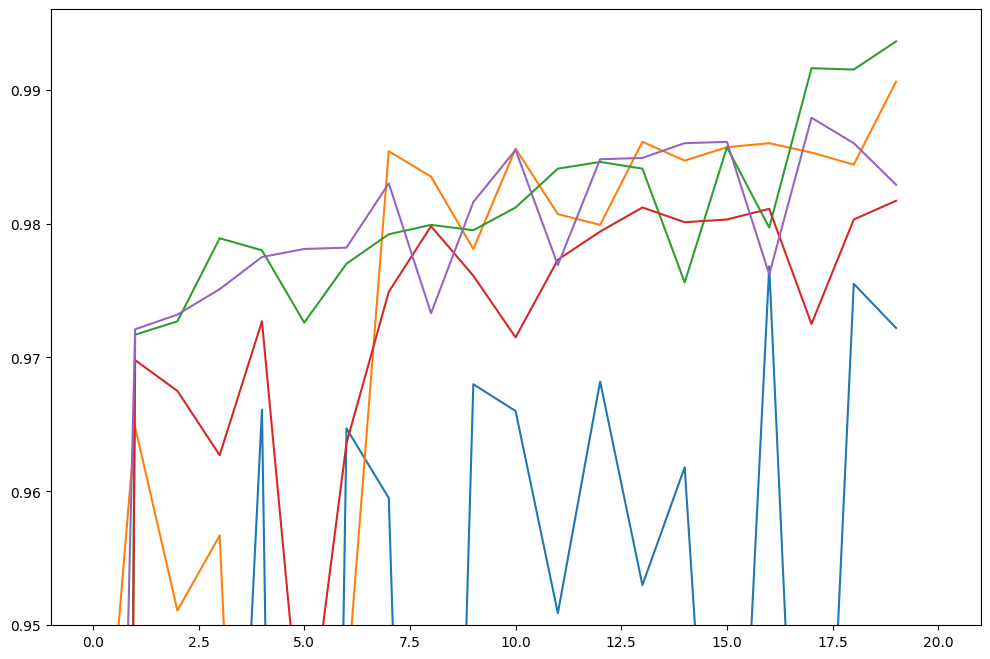

In [36]:
plot_history(hists, attribute='val_accuracy',axis=(-1,21,0.95,0.9960), loc='lower right')

In [ ]:
plot_history(hists, attribute='acc', axis=(-1,21,0.94,1.01), loc='lower right')

In [ ]:
plot_history(hists, attribute='val_loss', axis=(-1,21,0.02,0.18), loc='upper right')

In [ ]:
plot_history(hists, attribute='loss', axis=(-1,21,0.009,0.25), loc='upper right')